# 🔹 Анализ изображений(геоснимков)



### Sentinel‑2
Sentinel‑2 — это серия спутников Copernicus (ESA), которые снимают Землю мультиспектральной камерой и дают данные в видимом диапазоне, ближнем ИК (NIR) и коротковолновом ИК (SWIR).

### Анализ NDVI, NDMI, SWIR
Это расчёт показателей по каналам:
- **NDVI** — индекс “насколько зелёная/живая растительность” (использует Red и NIR).  
- **NDMI** — индекс, связанный с влажностью растительности/поверхности (использует NIR и SWIR).  
- **SWIR** — сами коротковолновые инфракрасные каналы, которые часто используют для оценки влажности, горелых участков и различения типов поверхности.

# 🔹 При работе будем использовать следующие файлы: 

## data.zip / папка `data` (файлы `.hdf5`)
- **Назначение:** содержит исходные данные для обучения и оценки модели.
- **Содержимое:** файлы с мультиспектральными изображениями (массивы пикселей с несколькими каналами/полосами).
- **Использование:** загрузка примеров в даталоадер, обучение, валидация, тестирование, визуальный контроль.

## default_partition.json
- **Назначение:** фиксирует разбиение датасета на обучающую, валидационную и тестовую выборки.
- **Содержимое:** списки идентификаторов примеров (id), распределённых по `train`, `valid`, `test`.
- **Использование:** обеспечивает воспроизводимость экспериментов и корректную оценку качества.

## label_map.json
- **Назначение:** задаёт соответствие между числовыми метками классов и их идентификаторами/названиями.
- **Содержимое:** отображение вида “индекс класса → строковый идентификатор”.
- **Использование:** корректное формирование целевых меток при обучении и интерпретация предсказаний модели.

## band_stats.json
- **Назначение:** предоставляет справочную информацию по спектральным каналам и их значениям.
- **Содержимое:** статистики по каналам (и часто — их порядок/обозначения), необходимые для корректной обработки данных.
- **Использование:** нормализация входов, построение корректных псевдо‑RGB изображений и вычисление спектральных индексов (например, NDVI/NDMI).


# 🔹 1. Проведем анализ данных

### в папке дата хранятся файлы формата hdf5

In [62]:
from pathlib import Path

data_files = list(Path("data").rglob("*"))
len(data_files), data_files[:10]


(18192,
 [PosixPath('data/id_9697.hdf5'),
  PosixPath('data/id_8985.hdf5'),
  PosixPath('data/id_18239.hdf5'),
  PosixPath('data/id_10609.hdf5'),
  PosixPath('data/id_12634.hdf5'),
  PosixPath('data/id_13926.hdf5'),
  PosixPath('data/id_6562.hdf5'),
  PosixPath('data/id_3760.hdf5'),
  PosixPath('data/id_6098.hdf5'),
  PosixPath('data/id_2872.hdf5')])

### посмотрим что хранится внутри файла(какие каналы)

In [63]:
import h5py

fp = h5_files[0]
with h5py.File(fp, "r") as f:
    print(list(f.keys()))


['01 - Coastal aerosol', '02 - Blue', '03 - Green', '04 - Red', '05 - Vegetation Red Edge', '06 - Vegetation Red Edge', '07 - Vegetation Red Edge', '08 - NIR', '08A - Vegetation Red Edge', '09 - Water vapour', '10 - SWIR - Cirrus', '11 - SWIR', '12 - SWIR']


### посмотрим размер каждого канала

In [64]:
with h5py.File(fp, "r") as f:
    for k in f.keys():
        print(k, f[k].shape, f[k].dtype)

01 - Coastal aerosol (64, 64) int16
02 - Blue (64, 64) int16
03 - Green (64, 64) int16
04 - Red (64, 64) int16
05 - Vegetation Red Edge (64, 64) int16
06 - Vegetation Red Edge (64, 64) int16
07 - Vegetation Red Edge (64, 64) int16
08 - NIR (64, 64) int16
08A - Vegetation Red Edge (64, 64) int16
09 - Water vapour (64, 64) int16
10 - SWIR - Cirrus (64, 64) int16
11 - SWIR (64, 64) int16
12 - SWIR (64, 64) int16


### посмотрим картинку по 3 каналам RGB

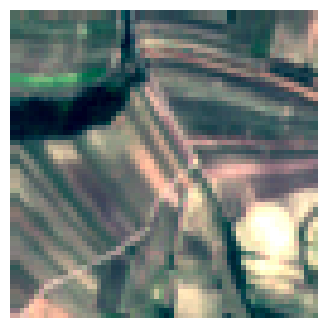

In [65]:
import numpy as np
import matplotlib.pyplot as plt

with h5py.File(fp, "r") as f:
    blue  = f["02 - Blue"][()]
    green = f["03 - Green"][()]
    red   = f["04 - Red"][()]

rgb = np.stack([red, green, blue], axis=-1).astype("float32")

p2, p98 = np.percentile(rgb, 2), np.percentile(rgb, 98)
rgb = np.clip((rgb - p2) / (p98 - p2 + 1e-6), 0, 1)

plt.figure(figsize=(4,4))
plt.imshow(rgb)
plt.axis("off")
plt.show()


### посмотрим содержание jsonов

In [66]:
import json

band_stats = json.load(open("band_stats.json"))
part = json.load(open("default_partition.json"))
label_map = json.load(open("label_map.json"))

In [67]:
part.keys()

dict_keys(['train', 'valid', 'test'])

In [68]:
{k: len(v) for k, v in part.items()}

{'train': 16200, 'valid': 996, 'test': 996}

In [69]:
len(label_map)

10

In [70]:
list(label_map.items())[:20]


[('0',
  ['id_0000',
   'id_0001',
   'id_0002',
   'id_0003',
   'id_0004',
   'id_0005',
   'id_0006',
   'id_0007',
   'id_0008',
   'id_0009',
   'id_0010',
   'id_0011',
   'id_0012',
   'id_0013',
   'id_0014',
   'id_0015',
   'id_0016',
   'id_0017',
   'id_0018',
   'id_0019',
   'id_0020',
   'id_0021',
   'id_0022',
   'id_0023',
   'id_0024',
   'id_0025',
   'id_0026',
   'id_0027',
   'id_0028',
   'id_0029',
   'id_0030',
   'id_0031',
   'id_0032',
   'id_0033',
   'id_0034',
   'id_0035',
   'id_0036',
   'id_0037',
   'id_0038',
   'id_0039',
   'id_0040',
   'id_0041',
   'id_0042',
   'id_0043',
   'id_0044',
   'id_0045',
   'id_0046',
   'id_0047',
   'id_0048',
   'id_0049',
   'id_0050',
   'id_0051',
   'id_0052',
   'id_0053',
   'id_0054',
   'id_0055',
   'id_0056',
   'id_0057',
   'id_0058',
   'id_0059',
   'id_0060',
   'id_0061',
   'id_0062',
   'id_0063',
   'id_0064',
   'id_0065',
   'id_0066',
   'id_0067',
   'id_0068',
   'id_0069',
   'id_0070',

In [71]:
band_stats.keys()

dict_keys(['01 - Coastal aerosol', '02 - Blue', '03 - Green', '04 - Red', '05 - Vegetation Red Edge', '06 - Vegetation Red Edge', '07 - Vegetation Red Edge', '08 - NIR', '08A - Vegetation Red Edge', '09 - Water vapour', '10 - SWIR - Cirrus', '11 - SWIR', '12 - SWIR', 'label'])

In [72]:
list(band_stats.keys())[:30]


['01 - Coastal aerosol',
 '02 - Blue',
 '03 - Green',
 '04 - Red',
 '05 - Vegetation Red Edge',
 '06 - Vegetation Red Edge',
 '07 - Vegetation Red Edge',
 '08 - NIR',
 '08A - Vegetation Red Edge',
 '09 - Water vapour',
 '10 - SWIR - Cirrus',
 '11 - SWIR',
 '12 - SWIR',
 'label']

т.е мы видим, что у нас есть 13 каналов (2 из которых SWIR 11,12)

Посмотрим ключи классов в label_map

In [73]:
import json
label_map = json.load(open("label_map.json"))
label_map.keys()


dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

Сколько файлов в каждом классе

In [74]:
{k: len(v) for k, v in label_map.items()}

{'0': 3000,
 '1': 3000,
 '2': 3000,
 '3': 2500,
 '4': 2500,
 '5': 2000,
 '6': 2500,
 '7': 3000,
 '8': 2500,
 '9': 3000}

In [75]:
label_map["0"][:20]

['id_0000',
 'id_0001',
 'id_0002',
 'id_0003',
 'id_0004',
 'id_0005',
 'id_0006',
 'id_0007',
 'id_0008',
 'id_0009',
 'id_0010',
 'id_0011',
 'id_0012',
 'id_0013',
 'id_0014',
 'id_0015',
 'id_0016',
 'id_0017',
 'id_0018',
 'id_0019']

## NDVI/NDMI/SWIR — это быстрый способ сжать многоканальный спутниковый снимок в понятные карты: где есть растительность, где она влажная/сухая, и какие поверхности отличаются по содержанию влаги/почвы/гарям. В нашем датасете это делается прямо из каналов 04 - Red, 08 - NIR, 11 - SWIR, 12 - SWIR, которые уже лежат в каждом .hdf5 под понятными именами.

 - NDVI=(B8−B4)/(B8+B4), то есть 08 - NIR и 04 - Red
 - NDMI=(B8−B11)/(B8+B11), то есть 08 - NIR и 11 - SWIR

## Рассмотрим на примере 1 файда в data


In [76]:
import h5py, numpy as np

fp = h5_files[0]

with h5py.File(fp, "r") as f:
    red  = f["04 - Red"][()].astype("float32")
    nir  = f["08 - NIR"][()].astype("float32")
    sw11 = f["11 - SWIR"][()].astype("float32")
    sw12 = f["12 - SWIR"][()].astype("float32")


посчитаем NDVI и NDMI

In [77]:
eps = 1e-6

ndvi = (nir - red) / (nir + red + eps)
ndmi11 = (nir - sw11) / (nir + sw11 + eps)
ndmi12 = (nir - sw12) / (nir + sw12 + eps)

визуализация для примера

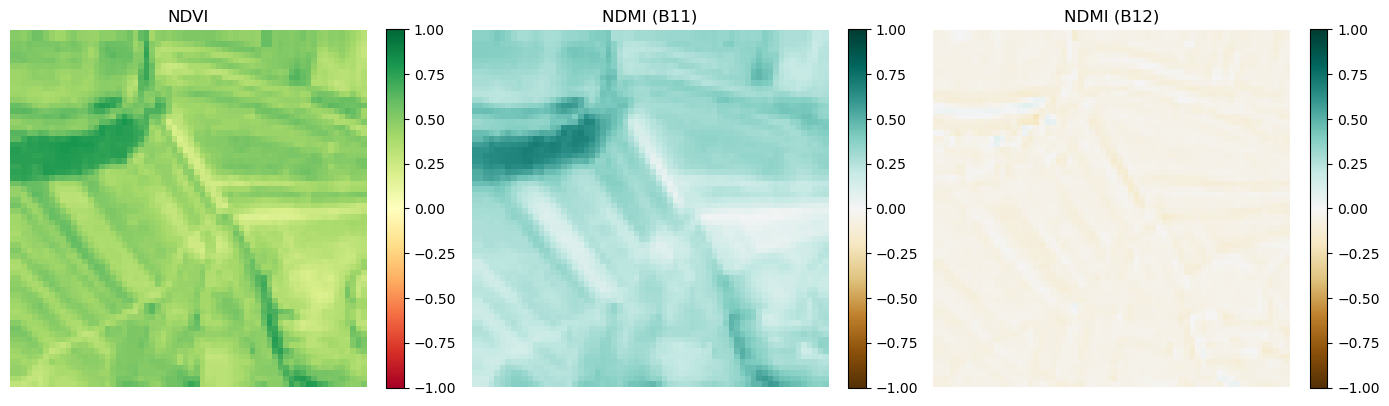

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
plt.title("NDVI")
plt.axis("off")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,2)
plt.imshow(ndmi11, cmap="BrBG", vmin=-1, vmax=1)
plt.title("NDMI (B11)")
plt.axis("off")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,3)
plt.imshow(ndmi12, cmap="BrBG", vmin=-1, vmax=1)
plt.title("NDMI (B12)")
plt.axis("off")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()


In [79]:
float(ndvi.mean()), float(np.median(ndvi)), float(ndmi11.mean())

(0.45327627658843994, 0.4479049742221832, 0.2892457842826843)

# 🔹 2. Предобработка данных и сборка даты для обучения 

будем брать 13 каналов и добалять еще к ним 2 индекса NDVI и NDMI
Каналы читаем из .hdf5 по именам, метки берём из label_map.json, а split — из default_partition.json.

Что мы хотим получить
 -  три объекта датасета — train_ds, valid_ds, test_ds, где каждый элемент — это:

 - X: тензор формы [15, H, W] (13 каналов Sentinel‑2 + NDVI + NDMI)​

 - y: число класса (int)

прочитаем json и разбиение по классам 

 - default_partition.json говорит, какие id относятся к train/valid/test.​

 - label_map.json говорит, какие id относятся к каждому классу.

In [93]:
part = json.load(open("default_partition.json"))
label_map = json.load(open("label_map.json"))

сделаем словарь id - класс (чтобы ускорить поиски в дальнейшем)

In [94]:
id2y = {}

for y_str, ids in label_map.items():
    y = int(y_str)        
    for _id in ids:
        id2y[_id] = y

собираем путь к файлу, y и значение split

In [95]:
from pathlib import Path

rows = []

for split in ["train", "valid", "test"]:
    for _id in part[split]:
        fp = Path("data") / f"{_id}.hdf5"  
        if fp.exists():
            rows.append((str(fp), id2y[_id], split))

получим: 

In [96]:
rows[0]

('data/id_15749.hdf5', 9, 'train')

In [97]:
len([r for r in rows if r[2]=="train"]), len([r for r in rows if r[2]=="valid"]), len([r for r in rows if r[2]=="test"])

(16200, 996, 996)

Разделим rows на trin/test/valid

In [98]:
train_rows = [r for r in rows if r[2] == "train"]
valid_rows = [r for r in rows if r[2] == "valid"]
test_rows  = [r for r in rows if r[2] == "test"]

На входе: один путь к файлу data/id_xxxx.hdf5.​
На выходе:
X = 15 каналов: 13 исходных + NDVI + NDMI
y = класс (число)
NDVI считается как (NIR−Red)/(NIR+Red)(NIR−Red)/(NIR+Red).​
NDMI считается как (NIR−SWIR)/(NIR+SWIR)(NIR−SWIR)/(NIR+SWIR) (для Sentinel‑2 часто берут SWIR=B11)

1. Берем уже собранный выше  список примеров train_rows/valid_rows/test_rows 

2. Создаём “сырое” чтение одного файла: 13 каналов + NDVI + NDMI -> 15 каналов.​

3. Считаем mean/std по train (по подвыборке, чтобы было быстро). Это нужно, чтобы привести все каналы к похожему масштабу и облегчить обучение.​

4. Создаём финальные Dataset и DataLoader, которые уже возвращают нормализованный X.​

читаем данные, ситаем статистики

In [99]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset

BANDS = [
 '01 - Coastal aerosol','02 - Blue','03 - Green','04 - Red',
 '05 - Vegetation Red Edge','06 - Vegetation Red Edge','07 - Vegetation Red Edge',
 '08 - NIR','08A - Vegetation Red Edge','09 - Water vapour','10 - SWIR - Cirrus',
 '11 - SWIR','12 - SWIR'
]

class H5S2_15ch_raw(Dataset):
    def __init__(self, rows):
        self.rows = rows

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, i):
        path, y, split = self.rows[i]

        with h5py.File(path, "r") as f:
            chans = []
            for b in BANDS:
                chans.append(f[b][()])
            x13 = np.stack(chans, axis=0).astype("float32")   # (13,H,W)

            red  = f["04 - Red"][()].astype("float32")
            nir  = f["08 - NIR"][()].astype("float32")
            swir = f["11 - SWIR"][()].astype("float32")

        eps = 1e-6 # чтобы не делить на 0
        ndvi = (nir - red) / (nir + red + eps)
        ndmi = (nir - swir) / (nir + swir + eps)

        x15 = np.concatenate([x13, ndvi[None, ...], ndmi[None, ...]], axis=0)  # (15,H,W)

        return torch.from_numpy(x15), torch.tensor(y, dtype=torch.long)


добавляем нормализацию
Нормализация требует 15 чисел mean и 15 чисел std (по одному на канал).​
Считать по всем 16k файлам можно долго, поэтому для начала берём, например, 500–2000 файлов train (это обычно достаточно).

In [100]:
raw_train_ds = H5S2_15ch_raw(train_rows)

N = 500   # можно 1000/2000 если терпимо по времени
idx = np.random.choice(len(raw_train_ds), size=min(N, len(raw_train_ds)), replace=False)

s1 = torch.zeros(15)  # сумма по каналам
s2 = torch.zeros(15)  # сумма квадратов по каналам
cnt = 0               # сколько пикселей всего суммарно (по одному каналу)

for i in idx:
    x, y = raw_train_ds[i]  # x: [15,H,W]
    s1 += x.mean(dim=(1,2))
    s2 += (x**2).mean(dim=(1,2))
    cnt += 1

mean = s1 / cnt
var = s2 / cnt - mean**2
std = torch.sqrt(torch.clamp(var, min=1e-6))

mean, std


(tensor([1.3370e+03, 1.0974e+03, 1.0186e+03, 9.1147e+02, 1.1577e+03, 1.9681e+03,
         2.3415e+03, 2.2692e+03, 7.1877e+02, 1.1832e+01, 1.7636e+03, 1.0753e+03,
         2.5618e+03, 3.4473e-01, 4.0893e-01]),
 tensor([2.3113e+02, 3.1319e+02, 3.7398e+02, 5.6521e+02, 5.4670e+02, 8.7400e+02,
         1.1091e+03, 1.1398e+03, 4.1092e+02, 4.3103e+00, 9.8614e+02, 7.3813e+02,
         1.2529e+03, 3.4342e-01, 2.7138e-01]))

сохраним mean/std на диск, чтобы потом не пересчитывать

In [101]:
torch.save({"mean": mean, "std": std}, "norm15.pt")

финал

In [102]:
class H5S2_15ch_norm(Dataset):
    def __init__(self, rows, mean, std):
        self.rows = rows
        self.mean = mean.view(15, 1, 1)  # чтобы работало broadcasting
        self.std  = std.view(15, 1, 1)

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, i):
        path, y, split = self.rows[i]

        with h5py.File(path, "r") as f:
            chans = []
            for b in BANDS:
                chans.append(f[b][()])
            x13 = np.stack(chans, axis=0).astype("float32")

            red  = f["04 - Red"][()].astype("float32")
            nir  = f["08 - NIR"][()].astype("float32")
            swir = f["11 - SWIR"][()].astype("float32")

        eps = 1e-6
        ndvi = (nir - red) / (nir + red + eps)
        ndmi = (nir - swir) / (nir + swir + eps)

        x15 = np.concatenate([x13, ndvi[None, ...], ndmi[None, ...]], axis=0)

        X = torch.from_numpy(x15)
        X = (X - self.mean) / self.std   # нормализация по каналам

        Y = torch.tensor(y, dtype=torch.long)
        return X, Y

создаем датсэты и лоадеры

In [103]:
train_ds = H5S2_15ch_norm(train_rows, mean, std)
valid_ds = H5S2_15ch_norm(valid_rows, mean, std)
test_ds  = H5S2_15ch_norm(test_rows,  mean, std)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=0)
valid_loader = DataLoader(valid_ds, batch_size=16, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False, num_workers=0)


In [104]:
bx, by = next(iter(train_loader))
bx.shape, by.shape, float(bx.mean()), float(bx.std())


(torch.Size([16, 15, 64, 64]),
 torch.Size([16]),
 0.26280972361564636,
 1.213720440864563)

дальше на этих данных уже можно обучать модель